# Ask

Sometimes a merchant may stop processing with us, which we call churn. We are interested in identifying and predicting churn. Please a) come up with a concrete definition for churn b) identify merchants that have already churned in the dataset

# Approach

We define churn as merchants no longer transacting on the platform, but given that some merchants don't process as frequently as others, we have to be careful about determining how long we wait after their last observed transaction to say that they've churned. 

We can define this cutoff based on experience and intuition, or we can derive it empirically. Ideally, the two would align, but when they don't we have to make a judgement call based on how the determination will be used. 

We may want to use churn projections for revenue projection, financial planning purposes, or platform health assessment purposes. In that case, our focus should be on correctness

On the other hand, we may want to understand why merchants are leaving, and get ahead of it. Here, shorter lead itimes are important, so that we actually have the time to do something to retain the merchant - as such, accuracy is less important than being directionally correct.

We'll take both these use cases into consideration when making our decision.

# Setup

## Installs and Imports

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lib.visualization import format_plot

## Config

### I/O

In [70]:
DATA_DIR = 'data/'
DATA_FILE = 'data_cleaned.csv'
MERCHANT_TYPES_FILE = 'merchant_types.csv'
OUT_DIR = 'output/'
OUTFILE = 'churned_merchants.csv'

### Visualization

In [71]:
# Tabular
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

# Plots
plt.rcParams['figure.figsize'] = [15, 3]

# Warnings
import warnings; warnings.filterwarnings(action='ignore')

# Read in Data

In [72]:
data = pd.read_csv(DATA_DIR + DATA_FILE)
print(f"Dimensions: {data.shape}")
data.head()

Dimensions: (1513501, 4)


,merchant,time,amount,time_diff_days
0,0002b63b92,2033-05-16 20:07:57,33.79,NaN
1,0002d07bba,2034-10-11 17:02:26,55.49,NaN
2,0002d07bba,2034-10-17 17:57:32,378.30,6.04
3,0002d07bba,2034-11-13 15:42:55,438.42,26.91
4,0002d07bba,2034-12-15 09:56:19,20.57,31.76


# Preprocessing

In [73]:
data['time'] = pd.to_datetime(data['time'])
data.sort_values(by=['merchant', 'time'], inplace=True)

# Time Between Transactions

Let's observe the distrubution of the amount of time that passes between transactions.

In [74]:
merch_freq = data.groupby('merchant')['time_diff_days']

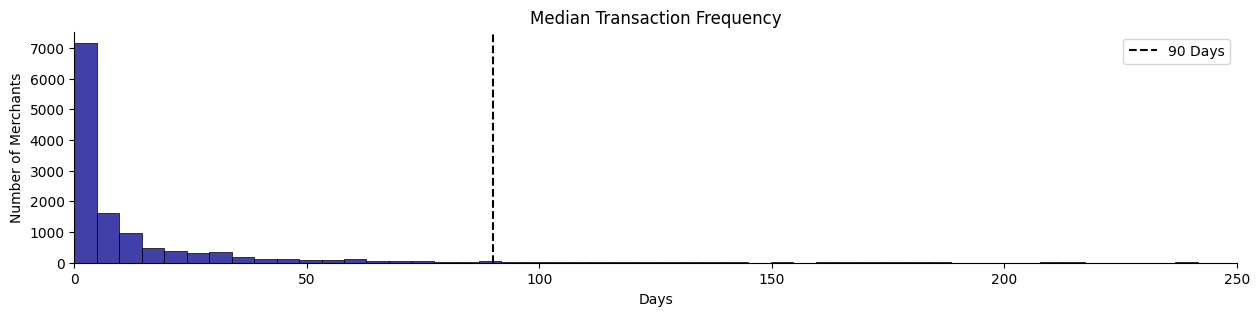

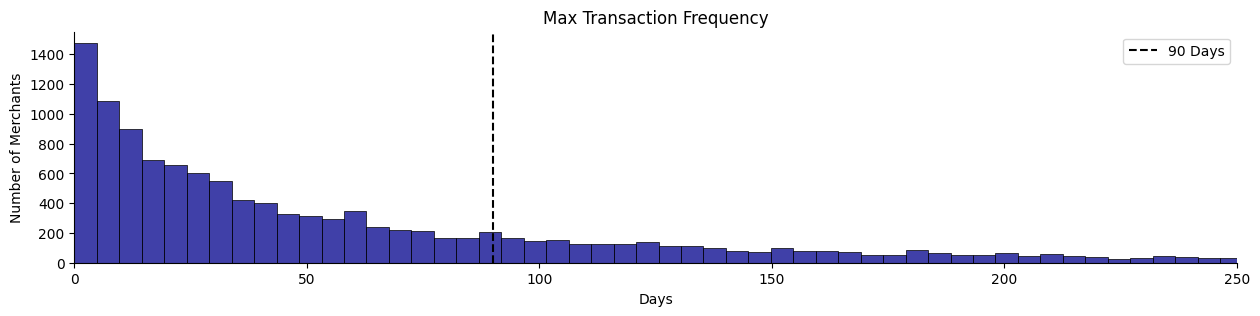

In [75]:
num_bins = 150
sns.histplot(merch_freq.median(), bins=num_bins, color='darkblue')
plt.axvline(90, color='black', linestyle='dashed', label='90 Days')
plt.xlim(0, 250) 
format_plot("Median Transaction Frequency", "Days", "Number of Merchants", legend=True)

sns.histplot(merch_freq.max(),  bins=num_bins, color='darkblue',)
plt.axvline(90, color='black', linestyle='dashed', label='90 Days')
plt.xlim(0, 250) 
format_plot("Max Transaction Frequency", "Days", "Number of Merchants", legend=True)

In [76]:
print(f"Median Transaction Frequency: {merch_freq.median().median()}")
print(f"Max time between transactions - 50th Percentile: {merch_freq.max().quantile(0.5)}")
print(f"Max time between transactions - 75th Percentile: {merch_freq.max().quantile(0.75)}")
print(f"Max time between transactions - 90th Percentile: {merch_freq.max().quantile(0.9)}")

Median Transaction Frequency: 3.11
Max time between transactions - 50th Percentile: 37.96
Max time between transactions - 75th Percentile: 98.37
Max time between transactions - 90th Percentile: 198.524


While the median amount of time between transactions is less than a month for the vast majority of merchants, half have a gap of more than a month between transactions at some point during their presence on the platform, more than 25% have a gap of more than 3 months, and 10% have a gap of more than 6 months. This means that if we categorize a merchant as having churned, after seeing no activity for 6 months, 1 in 10 of those merchants would be back on the platform at some point in the future.

It may be that as the platform and the businesses on it grow, the gaps between transactions lower, including at the extreme. Comparing data from the first half of 2033 with the second half on 2034 that doesn't appear to be the case. In fact, the amount of time between transactions seems to be going up - perhaps as older merchants become less active.

In [77]:
round(data[data['time'] < '2033-07-01'].groupby('merchant')['time_diff_days'].quantile(0.9).quantile(0.9), 1)

44.1

In [78]:
round(data[data['time'] > '2034-06-01'].groupby('merchant')['time_diff_days'].quantile(0.9).quantile(0.9), 1)

127.7

We could limit the remaining analysis to just the most recent year to account for these trends, but given that we just have two years of data, churn is usually measured at the order of months, and the platform has been steadily growing, we'll use both years to allow merchants to age into the platform

# Transaction Volume

## Most Recent Half and Quarter

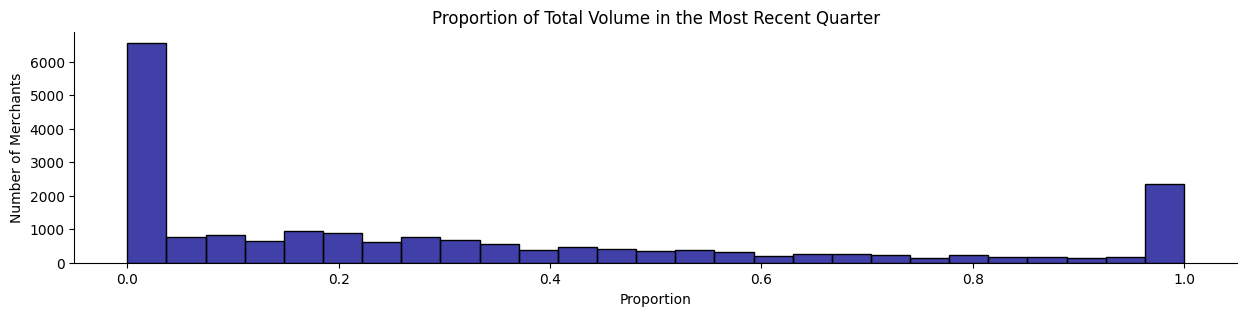

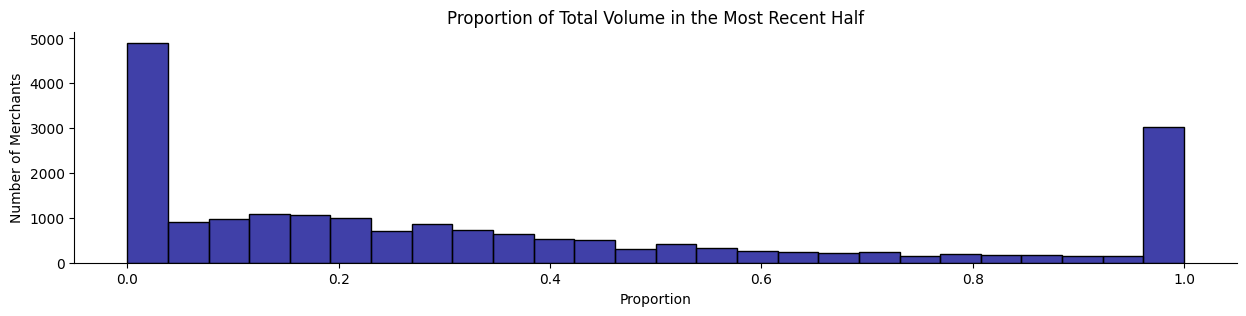

In [79]:
data['quarter'] = data['time'].dt.quarter
data['year'] = data['time'].dt.year
quarterly_volume = data.groupby(['merchant', 'quarter', 'year'])['amount'].sum().reset_index()
quarterly_volume.rename(columns={'amount': 'quarterly_volume'}, inplace=True)

Q434_volume = quarterly_volume[(quarterly_volume['quarter'] == 4) & (quarterly_volume['year'] == 2034)]
H234_volume = quarterly_volume[(quarterly_volume['quarter'].isin([3, 4])) & (quarterly_volume['year'] == 2034)]
H234_volume.rename(columns={'quarterly_volume': 'half_volume'}, inplace=True)

total_volume = data.groupby('merchant')['amount'].sum().reset_index()
total_volume.rename(columns={'amount': 'total_volume'}, inplace=True)

vol_int = total_volume.merge(Q434_volume, on='merchant', how='left')
vol_int = vol_int.merge(H234_volume, on='merchant', how='left')
vol_int['recent_prop_q'] = round(vol_int['quarterly_volume'] / vol_int['total_volume'], 2)
vol_int['recent_prop_h'] = round(vol_int['half_volume'] / vol_int['total_volume'], 2)
vol_int['recent_prop_q'].fillna(0, inplace=True)
vol_int['recent_prop_h'].fillna(0, inplace=True)

sns.histplot(vol_int['recent_prop_q'], color='darkblue')
format_plot("Proportion of Total Volume in the Most Recent Quarter", "Proportion", "Number of Merchants")

sns.histplot(vol_int['recent_prop_h'], color='darkblue')
format_plot("Proportion of Total Volume in the Most Recent Half", "Proportion", "Number of Merchants")

As expected, we observe a bimodal distribution of the proportion of merchant spend in H234 and Q434, indicating that some merchants have churned, others are still operating, and some have just joined the platform this quarter. 

## Variations in Volume Pre and Post Break

The increasing intervals between transactions over time may suggest that while transactions are still occurring, their volume may be significantly reduced. In other words, the merchant may still be transacting on the platform, but their value as a customer is reduced. 

In [80]:
def calculate_txvol_prop_pre_post_break(data: pd.DataFrame, gap_in_days: int) -> pd.DataFrame:
    # Determine the cutoff date
    first_postbreak_tx = data.loc[data[data['time_diff_days'] > gap_in_days].groupby('merchant')['time'].idxmin()][['merchant', 'time']]
    first_postbreak_tx.rename(columns={'time': 'first_post_break_tx_time'}, inplace=True)

    # Calculate transaction volume pre and post cutoff for each merchant
    cutoff_df = data.merge(first_postbreak_tx, on = "merchant", how = "inner")
    pre_cutoff_vol = cutoff_df[cutoff_df['time'] < cutoff_df['first_post_break_tx_time']].groupby('merchant')['amount'].sum()
    post_cutoff_vol = cutoff_df[cutoff_df['time'] >= cutoff_df['first_post_break_tx_time']].groupby('merchant')['amount'].sum()
    
    # Calculate proportions for each merchant
    post_cutoff_proportion = (round(post_cutoff_vol / pre_cutoff_vol, 2)).reset_index()
    post_cutoff_proportion.rename(columns={'amount': 'proportion'}, inplace=True)

    return post_cutoff_proportion

In [81]:
month_prop = calculate_txvol_prop_pre_post_break(data, 30)
two_month_prop = calculate_txvol_prop_pre_post_break(data, 60)
quarter_prop = calculate_txvol_prop_pre_post_break(data, 90)
half_prop = calculate_txvol_prop_pre_post_break(data, 180)

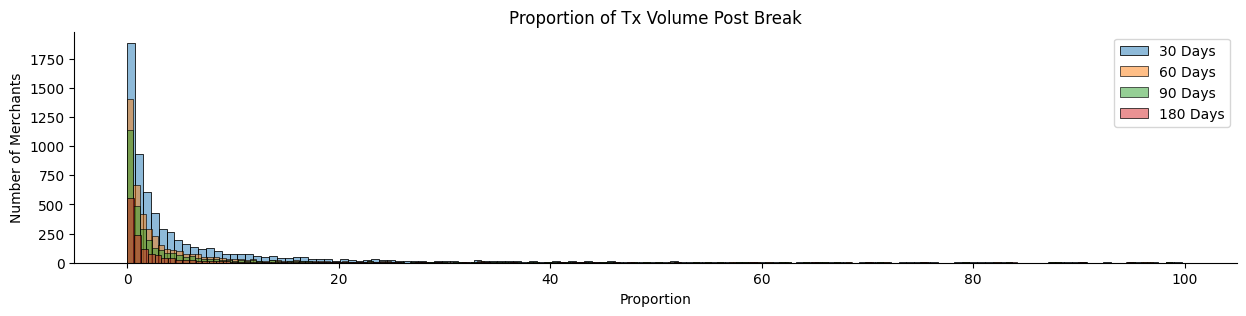

In [82]:
sns.histplot(data=month_prop[month_prop['proportion'] < 100]['proportion'], alpha = 0.5, label="30 Days")
sns.histplot(data=two_month_prop[two_month_prop['proportion'] < 100]['proportion'], alpha = 0.5, label="60 Days")
sns.histplot(data=quarter_prop[quarter_prop['proportion'] < 100]['proportion'], alpha = 0.5, label="90 Days")
sns.histplot(data=half_prop[half_prop['proportion'] < 100]['proportion'], alpha = 0.5, label="180 Days")
format_plot('Proportion of Tx Volume Post Break', 'Proportion', 'Number of Merchants', legend = True)

In [83]:
print(month_prop['proportion'].describe())
print(round(month_prop['proportion'].quantile(0.90), 1))

count     7165.000000
mean        75.210952
std        901.217325
min          0.000000
25%          0.690000
50%          2.470000
75%         10.020000
max      48361.290000
Name: proportion, dtype: float64
41.3


In [84]:
print(two_month_prop['proportion'].describe())
print(round(two_month_prop['proportion'].quantile(0.90), 1))

count     4857.000000
mean        54.057221
std        861.399926
min          0.000000
25%          0.460000
50%          1.650000
75%          6.460000
max      48361.290000
Name: proportion, dtype: float64
27.2


In [85]:
print(quarter_prop['proportion'].describe())
print(round(quarter_prop['proportion'].quantile(0.90), 1))

count     3504.000000
mean        37.921313
std        364.547320
min          0.000000
25%          0.360000
50%          1.380000
75%          5.602500
max      11734.020000
Name: proportion, dtype: float64
24.0


In [86]:
print(half_prop['proportion'].describe())
print(round(half_prop['proportion'].quantile(0.90), 1))

count     1504.000000
mean        35.470552
std        374.465585
min          0.000000
25%          0.297500
50%          1.170000
75%          4.557500
max      11734.020000
Name: proportion, dtype: float64
23.8


The hypothesis holds true - while there are some outliers, for merchants who have more than 90 days between transactions, 75% only post ~5% of their pre break volume post break, with 90% posting less than 25%. These numbers come down further when we extend the break to the 6 month mark, though not very significantly. These results hold for a 30 day gap as well, 50% of merchants just have 2% of their total transaction volume post break, while 75% have ~10%.

We're just working with a couple year's worth of data, so these number may be adjusted upward as time passes.

**The upshot of all of this is that if we a mark a merchant as having churned if they've had no activity for 90 days, there's a 1 in 4 chance that they'll come back to the platform. But even if they do, there's a very high likelihood that that their volume of transactions once they're back will be significantly lower than before.**

**These trends are stronger at the 6 month period, though mostly in terms of reappearing on the platform, the proportional change in transaction volume is similar to that following a three month break.**

# Definition

Now that we have some data, let's determine how long a period of inactivity needs to be before me mark a merchant as having churned.

If the goal is to be as precise as possible, for external reporting or topline metrics, 6 months is a good choice. Only 1 in 10 merchants come back after being away for that period, and when they do, they only return to a fraction of their pre break transaction volume.

Intuitively though, 6 months is a long time for a merchant to be completely absent - it could mean a pause in business activities, or time away to assess other platforms. As such, the period needs to be shorter if we want to evaluate platform health and user engagement. 3 months, or a quarter, is a good fit here - only 1 in 4 merchants come back after being away for 3 months, and even if they do, the transaction volume is still significantly lower (< 5% 75% of the time) than it was prior to them pausing activity.

3 months is a bit too long for modeling churn if the purpose is to get ahead of it, and try and retain at risk merchants. A merchant will have stopped transacting for weeks before we identify them as needing attention - a shorter period, say 2 months is a better bet for this use case.

A month is too short here since half of all merchants on the platform have gaps that long.

**In aggregate, 3 months is the best balance of different needs**. For internal reporting or financial planning, being a bit more aggressive will only lead to slightly more conservative projections, so the downside risk is low. It's also a largely reasonable time frame to model against. 

# Churned Merchants

We could approach this in two ways:
- Merchants who churned at some point in the last two years - there was more than a 3 month gap between transactions at any point in our dataset
- Merchants who've been inactive for the last three months

While the first approach is interesting from an academic perspective, what we care about it is merchants who are no longer active on the platform - corresponding to the second approach

## Time Since Last Transaction

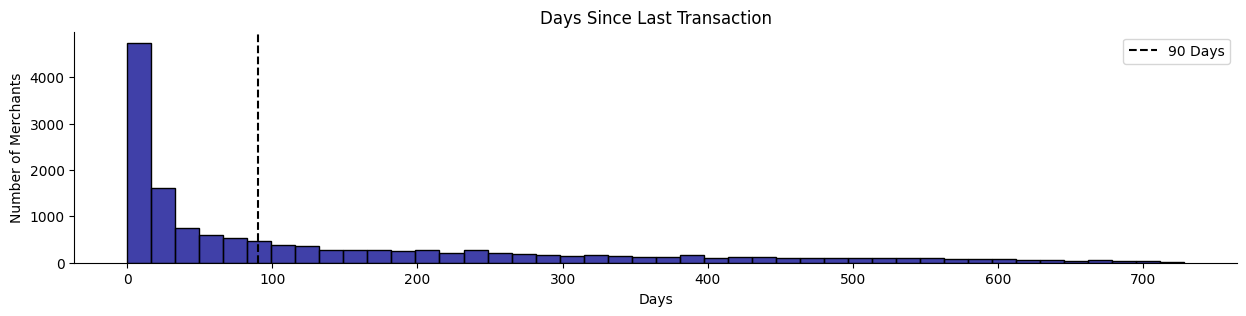

In [87]:
time_since_last_tx = (data['time'].max() - data.groupby('merchant')['time'].max()).reset_index()
time_since_last_tx['time'] = round(time_since_last_tx['time'].dt.total_seconds() / (3600 * 24), 1)
time_since_last_tx.rename(columns={'time': 'days_since_last_tx'}, inplace=True)
sns.histplot(time_since_last_tx['days_since_last_tx'], color='darkblue')
plt.axvline(90, color='black', linestyle='dashed', label='90 Days')
format_plot("Days Since Last Transaction", "Days", "Number of Merchants", legend=True)

## Churned Merchants

In [88]:
time_since_last_tx['churned'] = np.where(time_since_last_tx['days_since_last_tx'] >= 90, 1, 0)
print(f"Number of churned merchants: {time_since_last_tx['churned'].sum()}")

Number of churned merchants: 5894


In [89]:
churned_merchants = time_since_last_tx[time_since_last_tx['churned'] == 1][['merchant', 'days_since_last_tx']]
print(churned_merchants.shape)
churned_merchants.head()

(5894, 2)


,merchant,days_since_last_tx
0,0002b63b92,593.5
2,00057d4302,514.1
3,000bcff341,508.5
4,000ddbf0ca,576.8
7,001f7b7a4f,303.5


We'll leave the `days_since_last_tx` column in for future convenience

In [90]:
# churned_merchants.to_csv(OUT_DIR + OUTFILE, index=False)

# Usage
We can use this definition in a number of ways:
- Assess the health of the platform by looking at 1) the number and proportion of merchants who churn in any given period, and 2) the trend in churn rates over time
- Understand the types of merchants who are churning, or not churning, to guide our product strategy
- Assess the impact of our strategy and decisions (change in rates, new features etc.) on merchant retention, both in aggregate and on specific segments through the use of holdbacks, given that this is a long term metric
- Come up with revenue projections and improve the precision of financial planning methodologies

# Shortcomings

As discussed above, a 3 month lag time is too long to do something about retention - by the time the 3 months are over, or close to being over, the merchant will have already stopped transacting on the platform weeks ago. A shorter period would be better for use cases focused on retention and mitigating churn.

This approach won't work well for merchants who transact very infrequently. This isn't an issue if their transaction amounts are low, but high end merchants with high transaction amounts like the ones identified in our clustering analysis would show up as / at risk of churn incorrectly. They are a very small proportion of our user base, so it isn't a huge issue, but a note should be made to caveat churn annotations for that segment.

The approach also isn't robust to merchants using multiple IDs, as this dataset has no way of discerning that connection. While this won't have a bearing on financial planning, we may end up taking action to retain a merchant who isn't at risk of churning.

Lastly, a small proportion of merchants (e.g., `047a744051`, `18da26c984`) do buck the trend and come back after a hiatus with a sginificant increase in transaction volume - this may be inorganic behavior (test accounts), reflect a fundamental improvement in the healh of the business, or a migration of their traffic from a different provider to us allowing some time for development work. Given that these are a minority however, just being aware of the possibility while making decisions should suffice.

# Addendum - Merchant Types

In [91]:
mt = pd.read_csv(OUT_DIR + MERCHANT_TYPES_FILE)
time_since_last_tx = time_since_last_tx.merge(mt, on="merchant")
time_since_last_tx.shape

(14351, 4)

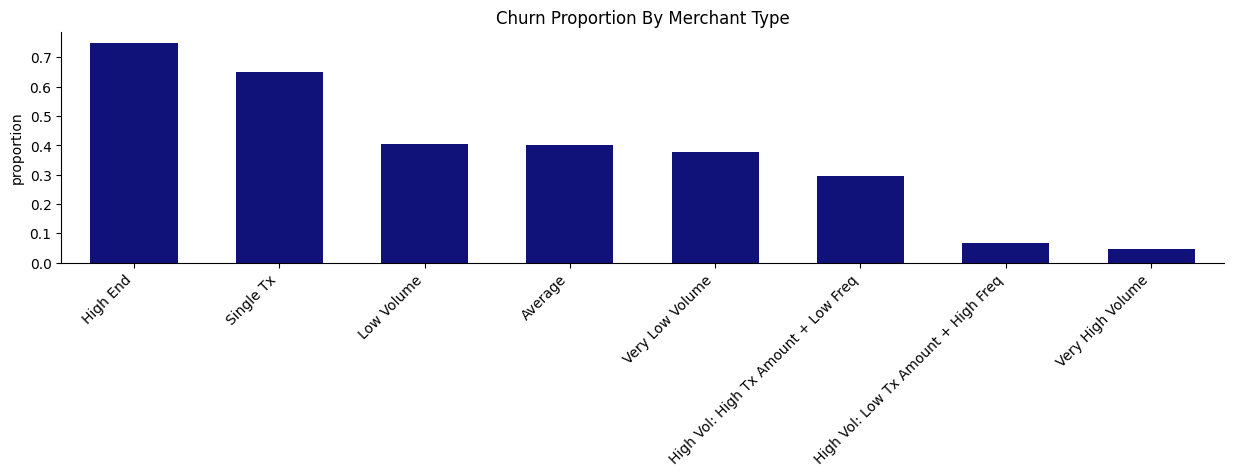

In [92]:
churn_prop = time_since_last_tx.groupby('category')['churned'].mean().reset_index()
churn_prop = churn_prop.sort_values(by='churned', ascending=False)
sns.barplot(data=churn_prop, x='category', y='churned', color='darkblue', width=0.6)
plt.xticks(rotation=45, ha='right')
format_plot('Churn Proportion By Merchant Type', '', 'proportion')

Low volume, low frequency merchants are more likely to churn, not least because the churn determination itself depends on an extended period of very low frequency.